# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import pickle
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data exploration and reorganizing

In [2]:
# Dataset: portfolio
portfolio.shape

(10, 6)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

In [5]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [6]:
# Dataset: profile
profile.shape

(17000, 5)

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    # drop membership starting date
    profile.drop(['became_member_on'], axis=1, inplace=True)
    
    
    return profile

In [9]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,age,gender,id,income,memberdays
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,863
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,930
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,578
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,654
12,58.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,744


In [10]:
cleaned_profile.describe()

,age,income,memberdays
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,1009.478988
std,17.383705,21598.299410,419.205158
min,18.000000,30000.000000,487.000000
25%,42.000000,49000.000000,695.000000
50%,55.000000,64000.000000,845.000000
75%,66.000000,80000.000000,1284.000000
max,101.000000,120000.000000,2310.000000


In [11]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    user_age = cleaned_profile['age'].plot(kind='hist', bins=50, title='Distribution of Customer Age')
    user_age.set_xlabel("Customer Age")
       
    # Display Histogram of the days being member
    plt.figure()
    memberdays = cleaned_profile['memberdays'].plot(kind='hist', bins=100, title='Distribution of membership period')
    memberdays.set_xlabel("Days")
    
    # Display Histogram of User Income
    plt.figure()
    user_income = cleaned_profile['income'].plot(kind='hist', bins=50, title='Distribution of Customer Income')
    user_income.set_xlabel("Income")

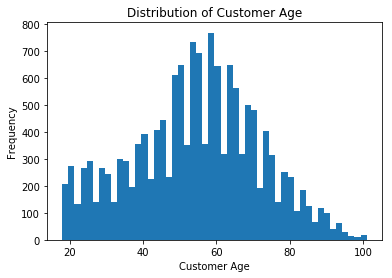

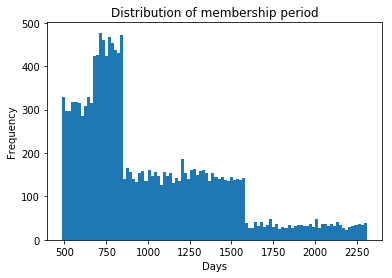

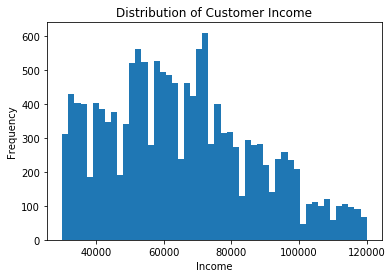

In [12]:
display_customer_profile()

In [13]:
# Dataset: transcript
transcript.shape

(306534, 4)

In [14]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [16]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [17]:
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [18]:
offer = clean_transcript(transcript)
offer.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [19]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [20]:
offer[offer['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
150598,offer received,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
163375,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,408,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
201572,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
218394,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd
218395,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d


In [21]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [33]:
#full_df = create_user_item_matrix(offer, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [22]:
full_df = pd.read_pickle('user_item_matrix.p')
full_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [23]:
train_size = int(offer.shape[0]*0.8)
test_size = offer.shape[0] - train_size
train_size, test_size

(134064, 33517)

In [24]:
train_offer = offer[:train_size]
test_offer = offer[train_size:]

In [37]:
#train_df = create_user_item_matrix(train_offer, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [25]:
train_df = pd.read_pickle('train_df.p')
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [31]:
#test_df = create_user_item_matrix(test_offer, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
fini

In [26]:
test_df = pd.read_pickle('test_df.p')
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [27]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [28]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.326997
2 		 0.285283
3 		 0.284829
4 		 0.284364
5 		 0.283895
6 		 0.283421
7 		 0.282942
8 		 0.282456
9 		 0.281964
10 		 0.281465
11 		 0.280959
12 		 0.280445
13 		 0.279921
14 		 0.279389
15 		 0.278846
16 		 0.278292
17 		 0.277726
18 		 0.277148
19 		 0.276555
20 		 0.275948
21 		 0.275324
22 		 0.274683
23 		 0.274024
24 		 0.273344
25 		 0.272642
26 		 0.271918
27 		 0.271168
28 		 0.270391
29 		 0.269585
30 		 0.268748
31 		 0.267878
32 		 0.266973
33 		 0.266029
34 		 0.265045
35 		 0.264018
36 		 0.262945
37 		 0.261823
38 		 0.260649
39 		 0.259420
40 		 0.258133
41 		 0.256784
42 		 0.255371
43 		 0.253890
44 		 0.252339
45 		 0.250713
46 		 0.249010
47 		 0.247227
48 		 0.245360
49 		 0.243409
50 		 0.241369
51 		 0.239240
52 		 0.237019
53 		 0.234705
54 		 0.232298
55 		 0.229796
56 		 0.227201
57 		 0.224513
58 		 0.221733
59 		 0.218864
60 		 0.215907
61 		 0.212866
62 		 0.209745
63 		 0.206548
64 		 0

In [29]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.309441
2 		 0.283685
3 		 0.283066
4 		 0.282440
5 		 0.281810
6 		 0.281177
7 		 0.280540
8 		 0.279899
9 		 0.279255
10 		 0.278605
11 		 0.277951
12 		 0.277292
13 		 0.276627
14 		 0.275957
15 		 0.275279
16 		 0.274595
17 		 0.273903
18 		 0.273204
19 		 0.272495
20 		 0.271777
21 		 0.271049
22 		 0.270311
23 		 0.269561
24 		 0.268798
25 		 0.268023
26 		 0.267233
27 		 0.266428
28 		 0.265606
29 		 0.264768
30 		 0.263910
31 		 0.263033
32 		 0.262135
33 		 0.261215
34 		 0.260270
35 		 0.259300
36 		 0.258303
37 		 0.257277
38 		 0.256221
39 		 0.255133
40 		 0.254011
41 		 0.252853
42 		 0.251657
43 		 0.250422
44 		 0.249145
45 		 0.247825
46 		 0.246458
47 		 0.245045
48 		 0.243581
49 		 0.242067
50 		 0.240498
51 		 0.238875
52 		 0.237195
53 		 0.235456
54 		 0.233657
55 		 0.231797
56 		 0.229875
57 		 0.227889
58 		 0.225839
59 		 0.223724
60 		 0.221545
61 		 0.219301
62 		 0.216992
63 		 0.214619
64 		 0

In [30]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.297043
2 		 0.286606
3 		 0.285483
4 		 0.284358
5 		 0.283234
6 		 0.282110
7 		 0.280987
8 		 0.279864
9 		 0.278743
10 		 0.277622
11 		 0.276502
12 		 0.275382
13 		 0.274264
14 		 0.273146
15 		 0.272030
16 		 0.270914
17 		 0.269799
18 		 0.268685
19 		 0.267571
20 		 0.266458
21 		 0.265347
22 		 0.264235
23 		 0.263125
24 		 0.262014
25 		 0.260905
26 		 0.259795
27 		 0.258686
28 		 0.257577
29 		 0.256468
30 		 0.255359
31 		 0.254249
32 		 0.253139
33 		 0.252028
34 		 0.250916
35 		 0.249804
36 		 0.248689
37 		 0.247573
38 		 0.246456
39 		 0.245336
40 		 0.244214
41 		 0.243088
42 		 0.241960
43 		 0.240829
44 		 0.239693
45 		 0.238554
46 		 0.237409
47 		 0.236260
48 		 0.235106
49 		 0.233945
50 		 0.232778
51 		 0.231605
52 		 0.230424
53 		 0.229235
54 		 0.228038
55 		 0.226832
56 		 0.225617
57 		 0.224392
58 		 0.223156
59 		 0.221909
60 		 0.220650
61 		 0.219379
62 		 0.218095
63 		 0.216797
64 		 0

In [32]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None

In [33]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [37]:
# Evaluation for latent features of 15
validation(test_df, user_mat, offer_mat)

0.348185179864


In [35]:
# Evaluation for latent features of 10
validation(test_df, user_mat_10, offer_mat_10)

0.350936830621


In [36]:
# Evaluation for latent features of 5
validation(test_df, user_mat_5, offer_mat_5)

0.335492245895


In [38]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [39]:
# recommend offer for a particular user
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.28
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.26
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.07
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.06
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  -0.04
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  -0.33
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  -0.6
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  -0.8


Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


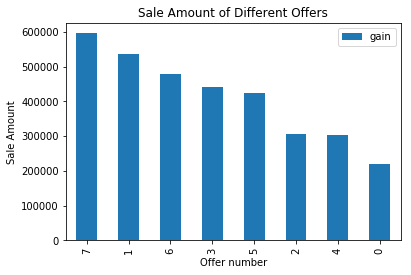

In [47]:
# we recommend top best sale offer to a new user
recommend_offer('new_user', user_mat, offer_mat)

In [41]:
def gender_offer(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

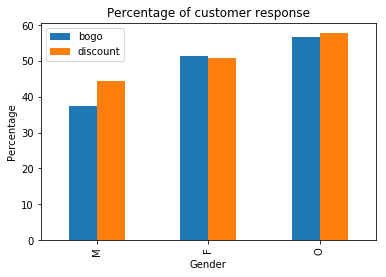

In [42]:
gender_offer(full_df)

In [43]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

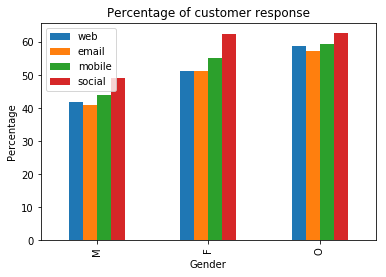

In [44]:
gender_offer_channel(full_df)

In [45]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


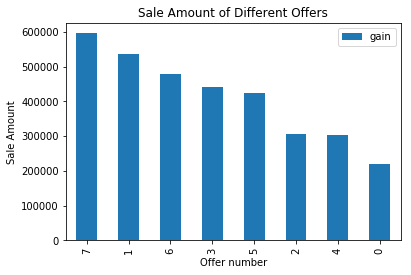

In [46]:
best_sale_offer(full_df)